In [1]:
!date

Sat Apr 19 05:37:21 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
%%time
#import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
#import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model

from torch.autograd import Function


CPU times: user 1.75 s, sys: 499 ms, total: 2.24 s
Wall time: 2.64 s


In [4]:
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns

In [5]:
import sys
from IPython import display
import pickle

In [6]:
from nilearn.glm.first_level import make_first_level_design_matrix

In [7]:
print(np.__version__)
print(sklearn.__version__)
print(torch.__version__)
print(ants.__version__)

1.20.1
1.3.2
2.4.1+cu121
0.5.4


In [ ]:
import os
import random
import numpy as np
import torch

def set_seed(seed: int):
    # 1) Python/hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    # 2) PyTorch CPU & GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # 3) CuDNN determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Choose any integer seed
SEED = 42
set_seed(SEED)

## Defining CVAE model and helper functions 

In [8]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [9]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*np.random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug

In [10]:
class cVAE(nn.Module):

    def __init__(self,conf,in_channels: int,in_dim: int, latent_dim: tuple,hidden_dims: List = None, beta : float = 1, gamma : float = 1, delta : float = 1, scale_MSE_GM : float = 1, scale_MSE_CF : float = 1, scale_MSE_FG : float = 1,do_disentangle = True, freq_exp : float = 1, freq_scale : float = 1) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.latent_dim_z = self.latent_dim[0]
        self.latent_dim_s = self.latent_dim[1]
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.scale_MSE_GM = scale_MSE_GM
        self.scale_MSE_CF = scale_MSE_CF
        self.do_disentangle = do_disentangle
        self.freq_exp = freq_exp
        self.freq_scale = freq_scale
        self.scale_MSE_FG = scale_MSE_FG
        self.confounds = conf.float()
        self.grl = GradientReversalLayer(lambda_=1.0)

        self.decoder_confounds_z = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[0], out_channels=128, 
                                   kernel_size=156, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )


        self.decoder_confounds_s = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[1], out_channels=128, 
                                   kernel_size=156, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )

    

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)


        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))
        self.decoder_input = nn.Linear(self.latent_dim_s+self.latent_dim_z, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.LeakyReLU()
                    )
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= self.in_channels,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]: # ORIGINAL
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        #output = self.decode(torch.cat((tg_z, tg_s),1))
        output = self.forward_bg(input)[0]+self.forward_fg(input)[0]
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        zeros = torch.zeros(tg_s.shape[0],self.latent_dim_z)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((zeros, tg_s),1))
        return  [output, input, tg_mu_s, tg_log_var_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_z, bg_log_var_z = self.encode_z(input)
        bg_z = self.reparameterize(bg_mu_z, bg_log_var_z)
        zeros = torch.zeros(bg_z.shape[0],self.latent_dim_s)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((bg_z, zeros),1))
        return  [output, input, bg_mu_z, bg_log_var_z]


    def ncc(self, x, y, eps = 1e-8):
        x = x.flatten(start_dim=1)  # Flatten spatial dimensions
        y = y.flatten(start_dim=1)

        x_mean = x.mean(dim=1, keepdim=True)
        y_mean = y.mean(dim=1, keepdim=True)

        x_std = x.std(dim=1, keepdim=True)
        y_std = y.std(dim=1, keepdim=True)

        ncc = (x - x_mean) * (y - y_mean) / (x_std * y_std + eps)
        ncc = ncc.mean(dim=1)

        return 1 - ncc  # Return 1 - NCC to minimize the loss 

    
        

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = self.beta
        gamma = self.gamma
        delta = self.delta
                          
        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_z = args[10]
        bg_log_var_z = args[11]
        
        recons_fg = self.forward_fg(input_tg)[0]
        
        
        # recons_loss_roi = F.mse_loss(recons_tg, input_tg) * self.scale_MSE_GM 
        # recons_loss_roni = F.mse_loss(recons_bg, input_bg) * self.scale_MSE_CF 
        recons_loss_roi = F.mse_loss(recons_tg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM #/ batch_size # TG reconstrction loss
        recons_loss_roni = F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:]) * self.scale_MSE_CF # / batch_size # BG reconstrction loss
        #recons_loss_roi+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM*.01
        recons_loss = recons_loss_roi+recons_loss_roni

        
        

        #recons_loss_fg = F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_fg(input_bg)[0][:,0,:])*1e2 # Denoised version of RONI, should be all zeros
        #recons_loss_fg+=F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_bg(recons_fg)[0][:,0,:])*1e2 # Noise features of FG should be all zeros

        confounds_pred_z = self.decoder_confounds_z(torch.unsqueeze(tg_z,2))
        confounds_pred_s = self.decoder_confounds_s(torch.unsqueeze(tg_s,2))

        loss_recon_conf_s = self.grl(F.mse_loss(confounds_pred_s, self.confounds))*1e2
        loss_recon_conf_z = F.mse_loss(confounds_pred_z, self.confounds)*1e2

        ncc_loss_tg = self.ncc(input_tg,recons_tg).mean()*1
        ncc_loss_bg = self.ncc(input_bg,recons_bg).mean()*1

        ncc_loss_conf_s = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_s +=  self.ncc(self.confounds[:,i,:],confounds_pred_s[:,i,:]).mean()*1e1
        ncc_loss_conf_s = self.grl(ncc_loss_conf_s)

        ncc_loss_conf_z = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_z += self.ncc(self.confounds[:,i,:],confounds_pred_z[:,i,:]).mean()*1e1

        #ncc_loss_conf_s*=1e2
        #ncc_loss_conf_z*=1e2


        recond_bg = self.forward_bg(input_tg)[0]
        fg_bg_ncc = model.ncc(recond_bg[:,0,:],recons_fg[:,0,:]).mean()
        recons_loss_fg = F.mse_loss(torch.zeros_like(fg_bg_ncc), 1-fg_bg_ncc)*1e4
        
        
        recons_loss+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:])*.0001
        recons_loss+=F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:])*.00001

        smoothness_loss = torch.mean((recons_fg[:,0,:][:, 1:] - recons_fg[:,0,:][:, :-1])**2)
        smoothness_loss+=torch.mean((recond_bg[:,0,:][:, 1:] - recond_bg[:,0,:][:, :-1])**2)
        smoothness_loss*=.01
        
        #ncc_losses = ncc_loss_tg+ncc_loss_bg+ncc_loss_conf_s+ncc_loss_conf_z
    
        do_disentangle=self.do_disentangle # Whether to do disentagling 
        disentangle_type = -1 # What type of disentangling to d
        fg_volatility_loss = torch.from_numpy(np.array(0)).to(device)
        total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)
        ncc_loss_conf_s = torch.from_numpy(np.array(0)).to(device)

        
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss = kld_loss/3
        kld_loss = kld_loss * beta
        

        #loss = torch.sum(recons_loss + kld_loss)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg)
        loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + recons_loss_fg + smoothness_loss + ncc_loss_conf_z + ncc_loss_conf_s)
        #loss = torch.sum(recons_loss + kld_loss + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + ncc_loss_conf_z + recons_loss_fg + smoothness_loss)
        #loss = torch.sum(recons_loss + kld_loss + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + +ncc_loss_conf_z +ncc_loss_tg + ncc_loss_bg + recons_loss_fg + smoothness_loss)
        

        return {
            'loss' : loss,
            'kld_loss' : kld_loss,
            'recons_loss_roi' : recons_loss_roi,
            'recons_loss_roni' : recons_loss_roni,
            'loss_recon_conf_s' : loss_recon_conf_s,
            'loss_recon_conf_z' : loss_recon_conf_z,
            'ncc_loss_tg' : ncc_loss_tg,
            'ncc_loss_bg' : ncc_loss_bg,
            'ncc_loss_conf_s' : ncc_loss_conf_s,
            'ncc_loss_conf_z' : ncc_loss_conf_z,
            'smoothness_loss' : smoothness_loss,
            'recons_loss_fg' : recons_loss_fg}
        
        # return {
        #         'loss' : loss.detach().cpu().numpy(),
        #         'kld_loss' : kld_loss.detach().cpu().numpy(),
        #         'recons_loss_roi' : recons_loss_roi.detach().cpu().numpy(),
        #         'recons_loss_roni' : recons_loss_roni.detach().cpu().numpy(),
        #         'loss_recon_conf_s' : loss_recon_conf_s.detach().cpu().numpy(),
        #         'loss_recon_conf_z' : loss_recon_conf_z.detach().cpu().numpy(),
        #         'ncc_loss_tg' : ncc_loss_tg.detach().cpu().numpy(),
        #         'ncc_loss_bg' : ncc_loss_bg.detach().cpu().numpy(),
        #         'ncc_loss_conf_s' : ncc_loss_conf_s.detach().cpu().numpy(),
        #         'ncc_loss_conf_z' : ncc_loss_conf_z.detach().cpu().numpy(),
        #         }
            
    

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

    def _compute_log_density_gaussian(self, z, mu, log_var):
            """
            Computes the log density of a Gaussian for each sample in the batch.
            """
            normalization = -0.5 * (math.log(2 * math.pi) + log_var)
            log_prob = normalization - 0.5 * ((z - mu) ** 2 / log_var.exp())
            return log_prob.sum(dim=1)

In [11]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

## Loading the subject specific data

In [12]:
# Specify Data Paths 
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

#gm_fn = os.path.join(indir,'mask_ffa-big.nii')
#cf_fn = os.path.join(indir,'mask_roni-2.nii')

cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')

# cf_fn = os.path.join(indir,'mask_roni.nii')
# gm_fn = os.path.join(indir,'mask_roi.nii')

brain_mask = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub,r=1)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

14/14


#### Specify the subject and the run to use

In [13]:
# Parameters for looping. 
s = 0 # index for subject (out of 14)
r = 1 # index for run (out of 4)
rep = 0 # Optional if doing multiple repetitions
analysis_name = 'test-lin' # This is be appended to the saved output files 

In [14]:
s = int(s) # If subID is passed from a terminal call (via papermill), make sure it's converted to int
r = int(r) # If runID is passed from a terminal call (via papermill), make sure it's converted to int

sub = subs[s] # Subjects BIDS ID
print(sub)

## Gather their niftis
epi = ants.image_read(epi_fn.format(sub=sub,r=r)) # BOLD data
gm = ants.image_read(gm_fn) # ROI mask
cf = ants.image_read(cf_fn) # RONI mask
brain = ants.image_read(brain_mask.format(sub=sub,r=r)) # Loose brain mask for after training

nt = epi.shape[-1] # Number of timepoints
ndummy = 0 # how many dummy scans to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() 
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
cf_flat = cf.numpy().flatten().astype(int) # (1082035,)

assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Assert that voxels in the ROI are NOT in the RONI and vice versa

sub-01


In [15]:
np.unique(gm.numpy().flatten()[gm.numpy().flatten()!=0])
np.unique(cf.numpy().flatten()[cf.numpy().flatten()!=0])

array([1.], dtype=float32)

In [16]:
#import pandas as pd
conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
df_conf = pd.read_csv(conf_fn,delimiter='\t')
assert np.isnan(df_conf.loc[:,['X','Y','Z','RotX','RotY','RotZ']].values).sum()==0,'NaNs in motion'
#conf = torch.permute(torch.tensor(df_conf.loc[:,['X','Y','Z','RotX','RotY','RotZ']].values), (1,0))
conf = df_conf.loc[:,['X','Y','Z','RotX','RotY','RotZ']].values.transpose()
print(df_conf.shape)
df_conf.head()

(156, 28)


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor05,Cosine00,Cosine01,Cosine02,X,Y,Z,RotX,RotY,RotZ
0,400.839614,318.636830,301.658923,NaN,NaN,NaN,NaN,-0.114180,0.060004,0.078100,...,-0.061136,0.113222,0.113205,0.113176,-0.004298,0.092861,-0.079594,0.001931,-0.000000,0.000000
1,400.921235,319.315018,301.961437,1.076607,16.922176,1.098864,0.057589,-0.078244,-0.057219,-0.053342,...,0.083976,0.113176,0.113021,0.112763,0.000000,0.059668,-0.070054,0.001720,-0.000000,0.000000
2,401.802523,319.604897,301.820800,1.101432,17.312384,1.026852,0.047126,-0.027331,-0.127769,0.134977,...,0.032267,0.113084,0.112654,0.111939,0.000024,0.059613,-0.075252,0.002110,0.000168,0.000279
3,400.327339,318.243918,301.665534,1.215010,19.097616,1.090247,0.105153,0.117361,-0.008332,0.014918,...,0.059260,0.112947,0.112105,0.110706,-0.000003,0.072699,-0.035038,0.001625,-0.000047,-0.000057
4,400.447552,318.126304,301.093015,1.108819,17.428497,1.044095,0.048414,0.074952,0.103966,-0.016375,...,-0.034357,0.112763,0.111373,0.109069,0.000031,0.059631,-0.049582,0.001676,0.000260,0.000000


In [17]:
# Create 3D coordinate grids
x_coords, y_coords, z_coords = np.meshgrid(
np.arange(gm.shape[0]),  # x-coordinates
np.arange(gm.shape[1]),  # y-coordinates
np.arange(gm.shape[2]),  # z-coordinates
indexing="ij"  # "ij" for matrix-style indexing
)
x_coords_flat = x_coords.flatten()
y_coords_flat = y_coords.flatten()
z_coords_flat = z_coords.flatten()

gm_x_coords = x_coords_flat[gm_flat.astype(bool)]
gm_y_coords = y_coords_flat[gm_flat.astype(bool)]
gm_z_coords = z_coords_flat[gm_flat.astype(bool)]
gm_coords = np.stack((gm_x_coords, gm_y_coords, gm_z_coords), axis=-1)

cf_x_coords = x_coords_flat[cf_flat.astype(bool)]
cf_y_coords = y_coords_flat[cf_flat.astype(bool)]
cf_z_coords = z_coords_flat[cf_flat.astype(bool)]
cf_coords = np.stack((cf_x_coords, cf_y_coords, cf_z_coords), axis=-1)

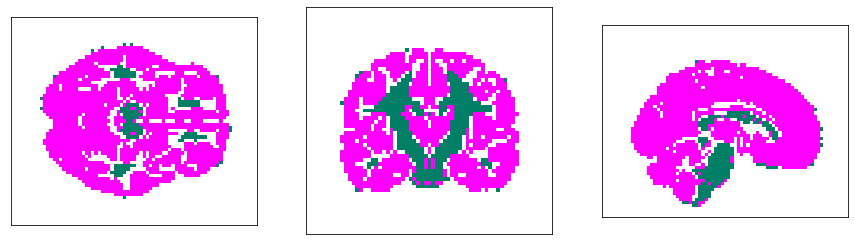

In [18]:
x,y,z = 30,39,20
#plt.figure(figsize=(15,5))
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
roi_slice = gm.numpy()[:,:,z]
roni_slice = cf.numpy()[:,:,z]
roi_slice[roi_slice<.01] = np.nan
roni_slice[roni_slice<.01] = np.nan
plt.imshow(roi_slice,cmap='spring')
plt.imshow(roni_slice,cmap='summer')
plt.xticks([]);
plt.yticks([]);

plt.subplot(1,3,2)
roi_slice = np.rot90(gm.numpy()[:,y,:])
roni_slice = np.rot90(cf.numpy()[:,y,:])
roi_slice[roi_slice<.01] = np.nan
roni_slice[roni_slice<.01] = np.nan
plt.imshow(roi_slice,cmap='spring')
plt.imshow(roni_slice,cmap='summer')
plt.xticks([]);
plt.yticks([]);

plt.subplot(1,3,3)
roi_slice = np.rot90(gm.numpy()[x,:,:])
roni_slice = np.rot90(cf.numpy()[x,:,:])
roi_slice[roi_slice<.001] = np.nan
roni_slice[roni_slice<.001] = np.nan
plt.imshow(roi_slice,cmap='spring')
plt.imshow(roni_slice,cmap='summer')
plt.xticks([]);
plt.yticks([]);
plt.show()

In [19]:
# How many voxels in RONI and ROI
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(9519, 44212)

In [20]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(300300, 156)
44212
9519


In [21]:
func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data

In [22]:
# func_gm = func_gm-func_gm.mean(axis=0)
# func_cf = func_cf-func_cf.mean(axis=0)

In [23]:
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [24]:
# Task regressors
events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 2.0 
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

#face_reg = X1['face'].values
#place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)

face_reg = X1[['face','body']].values.sum(axis=1)
place_reg = X1[['house', 'object', 'scene', 'scramble']].values.sum(axis=1)

# ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
# func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
# ffa_coords = gm_coords[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
# ffa_scaler = Scaler(func_ffa)
# ffa_list = ffa_scaler.transform(func_ffa)

# plt.figure(figsize=(15,5))
# plt.plot(ffa_list[:,:].mean(axis=0))
# plt.plot(func_cf.mean(axis=0)-func_cf.mean(axis=0).mean())
# plt.plot(face_reg,alpha=.5)
# plt.plot(place_reg,alpha=.5)
# plt.title('ffa activity + regs\n'+'ffa corr w/ face: {:.2f}\nffa corr w/ place: {:.2f}'.format(np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1],np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]))

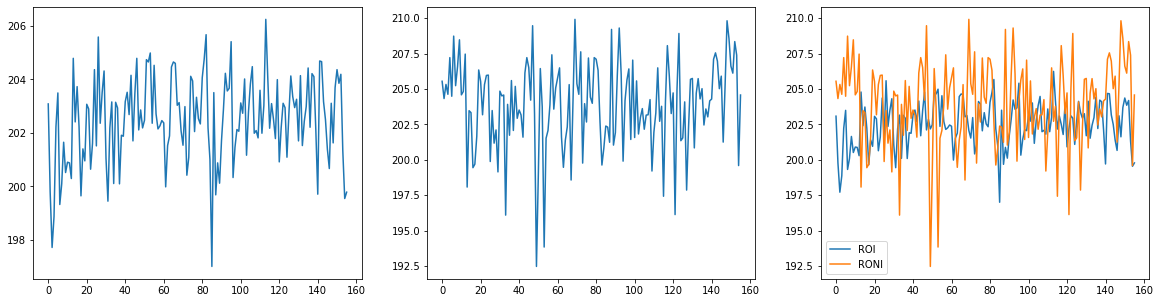

In [25]:
# Plot first voxel in ROI, RONI and both
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [26]:
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [27]:
# #Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
# func_gm = remove_std0(func_gm)
# func_cf = remove_std0(func_cf)
# print(func_gm.shape)
# print(func_cf.shape)

In [28]:
# # Apply scaler to ROI and RONI
# obs_scale = Scaler(func_gm)
# obs_list = obs_scale.transform(func_gm)
# print(obs_list.shape)
# noi_scale = Scaler(func_cf)
# noi_list = noi_scale.transform(func_cf)
# print(noi_list.shape)

In [29]:
obs_list = func_gm
noi_list = func_cf

(array([1.30272e+05, 3.69860e+04, 2.85210e+04, 8.86030e+04, 9.76012e+05,
        1.86882e+05, 2.32930e+04, 1.34950e+04, 7.43000e+02, 1.57000e+02]),
 array([-24.542044,  47.631973, 119.80599 , 191.98001 , 264.15402 ,
        336.32803 , 408.50204 , 480.67606 , 552.8501  , 625.0241  ,
        697.1981  ], dtype=float32),
 <BarContainer object of 10 artists>)

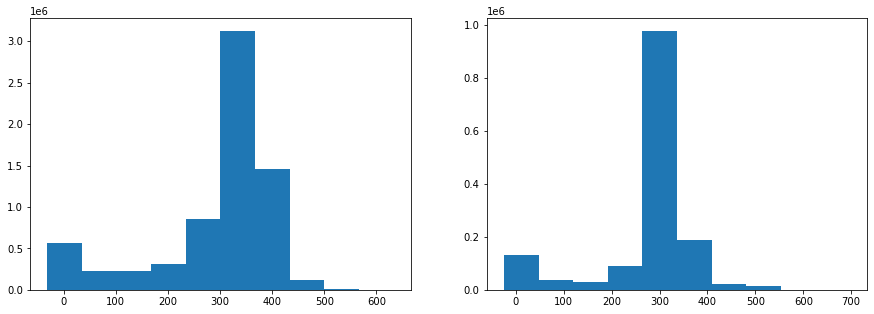

In [30]:
# Plot histograms for ROI and RONI
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())
plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [31]:

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Pass the input as is

    @staticmethod
    def backward(ctx, grad_output):
        lambda_ = ctx.lambda_
        grad_input = grad_output.neg() * lambda_  # Reverse and scale gradients
        return grad_input, None  # Second element corresponds to lambda_, which has no gradient

class GradientReversalLayer(torch.nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [32]:

now = datetime.now
t0 = now()

In [33]:
# batch_size = 1024
# latent_dim = (128,128) # Shared,Specific
# beta = 0.001       
# gamma = 0 # TC scaling
# delta = 1000 # "Denoised RONI should be zero" scaling
# scale_MSE_GM = 1e3 # Scale ROI loss 
# scale_MSE_CF = 1e4 # Scale RONI loss

# # gamma = 100 # TC scaling
# #scale_MSE_GM = 1e2 # Scale ROI loss 
# #scale_MSE_CF = 1e2 # Scale RONI loss
# scale_MSE_FG = 0 # "Denoised should be similar to input" scaling
# #beta = 0.0001  

# #train_inputs = TrainDataset(obs_list,noi_list)
# #train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
# #train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)

# obs_list_coords = np.concatenate([obs_list[:,:,np.newaxis],np.stack([gm_coords for _ in range(nt)],axis=1)],axis=-1)
# noi_list_coords = np.concatenate([noi_list[:,:,np.newaxis],np.stack([cf_coords for _ in range(nt)],axis=1)],axis=-1)
# obs_list_coords = np.swapaxes(obs_list_coords,1,2)
# noi_list_coords = np.swapaxes(noi_list_coords,1,2)
# train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
# train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Tensor = TypeVar('torch.tensor')
# conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)
# model = cVAE(conf_batch,4,func_cf.shape[1],latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
# model.to(device)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# dataloader_iter_in = iter(train_in_coords)
# inputs_gm,inputs_cf = next(dataloader_iter_in)
# inputs_gm = inputs_gm.float().to(device)
# inputs_cf = inputs_cf.float().to(device)

# [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
# [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)

# loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)

In [34]:
obs_list_coords = np.concatenate([obs_list[:,:,np.newaxis],np.stack([gm_coords for _ in range(nt)],axis=1)],axis=-1)
noi_list_coords = np.concatenate([noi_list[:,:,np.newaxis],np.stack([cf_coords for _ in range(nt)],axis=1)],axis=-1)
obs_list_coords = np.swapaxes(obs_list_coords,1,2)
noi_list_coords = np.swapaxes(noi_list_coords,1,2)

In [35]:
std0_gm = obs_list_coords[:,0,:].std(axis=-1)<1e-3
std0_cf = noi_list_coords[:,0,:].std(axis=-1)<1e-3
print(std0_gm.sum())
print(std0_cf.sum())

print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))
obs_list_coords = obs_list_coords[~std0_gm,:,:]
noi_list_coords = noi_list_coords[~std0_cf,:,:]
print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))

3096
427
44212/9519
41116/9092


In [36]:
# ### NORMALIZE WAY 1
# obs_list_coords_max_vals = obs_list_coords[:,0,:].max()
# obs_list_coords_min_vals = obs_list_coords[:,0,:].min()
# obs_list_coords_max_coords = obs_list_coords[:,:,0].max(axis=0)
# obs_list_coords_min_coords = obs_list_coords[:,:,0].min(axis=0)

# obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]-obs_list_coords_min_vals) / (obs_list_coords_max_vals-obs_list_coords_min_vals)
# obs_list_coords[:,1,:] = (obs_list_coords[:,1,:]-obs_list_coords_min_coords[1]) / (obs_list_coords_max_coords[1]-obs_list_coords_min_coords[1])
# obs_list_coords[:,2,:] = (obs_list_coords[:,2,:]-obs_list_coords_min_coords[2]) / (obs_list_coords_max_coords[2]-obs_list_coords_min_coords[2])
# obs_list_coords[:,3,:] = (obs_list_coords[:,3,:]-obs_list_coords_min_coords[3]) / (obs_list_coords_max_coords[3]-obs_list_coords_min_coords[3])

# noi_list_coords_max_vals = noi_list_coords[:,0,:].max()
# noi_list_coords_min_vals = noi_list_coords[:,0,:].min()
# noi_list_coords_max_coords = noi_list_coords[:,:,0].max(axis=0)
# noi_list_coords_min_coords = noi_list_coords[:,:,0].min(axis=0)

# noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]-noi_list_coords_min_vals) / (noi_list_coords_max_vals-noi_list_coords_min_vals)
# noi_list_coords[:,1,:] = (noi_list_coords[:,1,:]-noi_list_coords_min_coords[1]) / (noi_list_coords_max_coords[1]-noi_list_coords_min_coords[1])
# noi_list_coords[:,2,:] = (noi_list_coords[:,2,:]-noi_list_coords_min_coords[2]) / (noi_list_coords_max_coords[2]-noi_list_coords_min_coords[2])
# noi_list_coords[:,3,:] = (noi_list_coords[:,3,:]-noi_list_coords_min_coords[3]) / (noi_list_coords_max_coords[3]-noi_list_coords_min_coords[3])

In [37]:
# Z score 
obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]-obs_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,0,:].std(axis=1)[:,np.newaxis]
noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]-noi_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,0,:].std(axis=1)[:,np.newaxis]

In [38]:
# # Normalize 0-1
# obs_list_coords_min_vals = obs_list_coords[:,0,:].min(axis=-1)
# obs_list_coords_max_vals = obs_list_coords[:,0,:].max(axis=-1)
# obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]-obs_list_coords_min_vals[:,np.newaxis]) / (obs_list_coords_max_vals[:,np.newaxis]-obs_list_coords_min_vals[:,np.newaxis])

# noi_list_coords_min_vals = noi_list_coords[:,0,:].min(axis=-1)
# noi_list_coords_max_vals = noi_list_coords[:,0,:].max(axis=-1)
# noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]-noi_list_coords_min_vals[:,np.newaxis]) / (noi_list_coords_max_vals[:,np.newaxis]-noi_list_coords_min_vals[:,np.newaxis])

In [39]:
ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
#ffa_list_coords = obs_list_coords[ffa_im.numpy().flatten()[gm_flat==1]==1,:,:]
ffa_list_coords = obs_list_coords[(ffa_im.numpy().flatten()[gm_flat==1]==1)[~std0_gm],:,:]

In [40]:
conf_pcs = PCA(n_components=5).fit_transform(noi_list_coords[:,0,:].transpose())
lin_reg = linear_model.LinearRegression()
lin_reg.fit(conf_pcs,ffa_list_coords[:,0,:].transpose());
ffa_compcorr = ffa_list_coords[:,0,:].transpose()-lin_reg.predict(conf_pcs)
ffa_compcorr = ffa_compcorr.transpose()

In [41]:
np.corrcoef(ffa_list_coords[:,0,:].mean(axis=0),face_reg)[0,1].round(4)

0.6893

In [42]:
np.corrcoef(ffa_compcorr.mean(axis=0),face_reg)[0,1].round(4)

0.7113

In [43]:
if obs_list_coords.shape[0]>noi_list_coords.shape[0]:
    n_pad = obs_list_coords.shape[0]-noi_list_coords.shape[0]
    pad_idx = np.random.randint(low=0,high=noi_list_coords.shape[0],size=n_pad)
    noi_list_coords = np.concatenate([noi_list_coords,np.array([noi_list_coords[i,:,:] for i in pad_idx])])
    print(obs_list_coords.shape)
    print(noi_list_coords.shape)

(41116, 4, 156)
(41116, 4, 156)


In [44]:
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())

In [45]:
def show_bashboard(single_fig=True):

    nrows=5
    ncols=9
    sp=0
    
    if single_fig==True:
        plt.close()
        sys.stdout.flush()
        display.clear_output(wait=True);
        display.display(plt.gcf());
        plt.figure(figsize=(5*ncols,5*nrows))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['l']);plt.title('total loss: {:.2f}'.format(track['l'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['batch_varexp']);plt.title('batch_varexp: {:.2f}'.format(track['batch_varexp'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['varexp']);plt.title('FFA varexp: {:.2f}'.format(track['varexp'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ffa_io']);plt.title('ffa_io: {:.2f}'.format(track['ffa_io'][-1]))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roi']);plt.title('recons_loss_roi: {:.2f}'.format(track['recons_loss_roi'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roni']);plt.title('recons_loss_roni: {:.2f}'.format(track['recons_loss_roni'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_s']);plt.title('loss_recon_conf_s: {:.2f}'.format(track['loss_recon_conf_s'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['kld_loss']);plt.title('kld_loss: {:.2f}'.format(track['kld_loss'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_z']);plt.title('loss_recon_conf_z: {:.2f}'.format(track['loss_recon_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_tg']);plt.title('ncc_loss_tg: {:.2f}'.format(track['ncc_loss_tg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_bg']);plt.title('ncc_loss_bg: {:.2f}'.format(track['ncc_loss_bg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_fg']);plt.title('recons_loss_fg: {:.2f}'.format(track['recons_loss_fg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_s']);plt.title('ncc_loss_conf_s: {:.2f}'.format(track['ncc_loss_conf_s'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_z']);plt.title('ncc_loss_conf_z: {:.2f}'.format(track['ncc_loss_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['smoothness_loss']);plt.title('smoothness_loss: {:.2f}'.format(track['smoothness_loss'][-1]))
    
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(batch_in[0,0,:])
    plt.plot(batch_out[0,0,:])
    plt.plot(model.forward_bg(inputs_gm)[0].detach().cpu().numpy()[0,0,:],'r-')
    plt.plot(model.forward_fg(inputs_gm)[0].detach().cpu().numpy()[0,0,:],'g-')
    plt.title('batch timecourse (single voxel)')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    plt.plot(recon.mean(axis=0))
    plt.title('FFA AVG')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    plt.plot(signal.mean(axis=0),'g-')
    plt.plot(face_reg)
    plt.title('FFA SIGNAL')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(ffa_list_coords.mean(axis=0)[0,:])
    plt.plot(noise.mean(axis=0),'r-')
    plt.plot(face_reg)
    plt.title('FFA NOISE')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(inputs_cf.detach().cpu().numpy()[0,0,:])
    plt.plot(model.forward_bg(inputs_cf)[0].detach().cpu().numpy()[0,0,:])
    plt.plot(model.forward_fg(inputs_cf)[0].detach().cpu().numpy()[0,0,:])
    plt.title('CF batch voxel')
    
    idx = 3
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(confounds_pred_z[0,idx,:])
    plt.plot(conf[idx,:])
    plt.title('conf from z')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(confounds_pred_s[0,idx,:])
    plt.plot(conf[idx,:])
    plt.title('conf from s')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    idx = 2
    plt.plot(batch_in[0:25,idx,0])
    plt.plot(batch_out[0:25,idx,0])
    plt.title('batch coords')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(ffa_list_coords[:,idx,0])
    plt.plot(recon_coords[:,idx,0])
    plt.title('FFA coords')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['r_ffa_reg'],'k-')
    plt.plot(track['r_TG_reg'])
    plt.title('R TG-REG {}'.format(track['r_TG_reg'][-1]))
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['r_ffa_reg'],'k-')
    if single_fig==True:
        plt.plot(track['r_FG_reg'],'g-')
    else:
        plt.plot(track['r_FG_reg'])
        
    plt.title('R FG-REG {}'.format(track['r_FG_reg'][-1]))
    
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['r_ffa_reg'],'k-')
    plt.plot(track['r_BG_reg'],'r-')
    plt.title('R BG-REG {}'.format(track['r_BG_reg'][-1]))


    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(bg_mu_z[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(tg_mu_z[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(tg_mu_s[0,:].detach().cpu().numpy(), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.legend(['bg_mu_z','tg_mu_z','tg_mu_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(np.exp(0.5 * bg_log_var_z[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(np.exp(0.5 * tg_log_var_z[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.hist(np.exp(0.5 * tg_log_var_s[0,:].detach().cpu().numpy()), bins=10, histtype='step', label='Data 1', linewidth=2)
    plt.legend(['bg_log_var_z','tg_log_var_z','tg_log_var_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_mu_z'])
    plt.title('tg_mu_z over time')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_log_var_z'])
    plt.title('tg_log_var_z over time')

    #plt.suptitle(f'E:{epoch} T:{elapsed}',y=.91,fontsize=20)
    if single_fig==True:
        plt.suptitle(f'{sub}-R{r}-rep-{rep} E:{epoch} T:{elapsed}',y=.91,fontsize=20)
        plt.show()

In [46]:
def init_track():
    track = {}
    track['l'] = []
    track['kld_loss'] = []
    track['recons_loss_roi'] = []
    track['recons_loss_roni'] = []
    track['loss_recon_conf_s'] = []
    track['loss_recon_conf_z'] = []
    track['ncc_loss_tg'] = []
    track['ncc_loss_bg'] = []
    track['ncc_loss_conf_s'] = []
    track['ncc_loss_conf_z'] = []
    track['smoothness_loss'] = []
    track['recons_loss_fg'] = []
    track['r_ffa_reg'] = []
    track['r_TG_reg'] = []
    track['r_FG_reg'] = []
    track['r_BG_reg'] = []
    track['varexp'] = []
    track['batch_varexp'] = []
    track['ffa_io'] = []
    track['tg_mu_z'] = []
    track['tg_log_var_z'] = []
    track['tg_mu_s'] = []
    track['tg_log_var_s'] = []
    track['tg_z'] = []
    track['tg_s'] = []
    track['bg_log_var_z'] = []
    track['bg_mu_z'] = []
    return track

In [47]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test-lin


In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

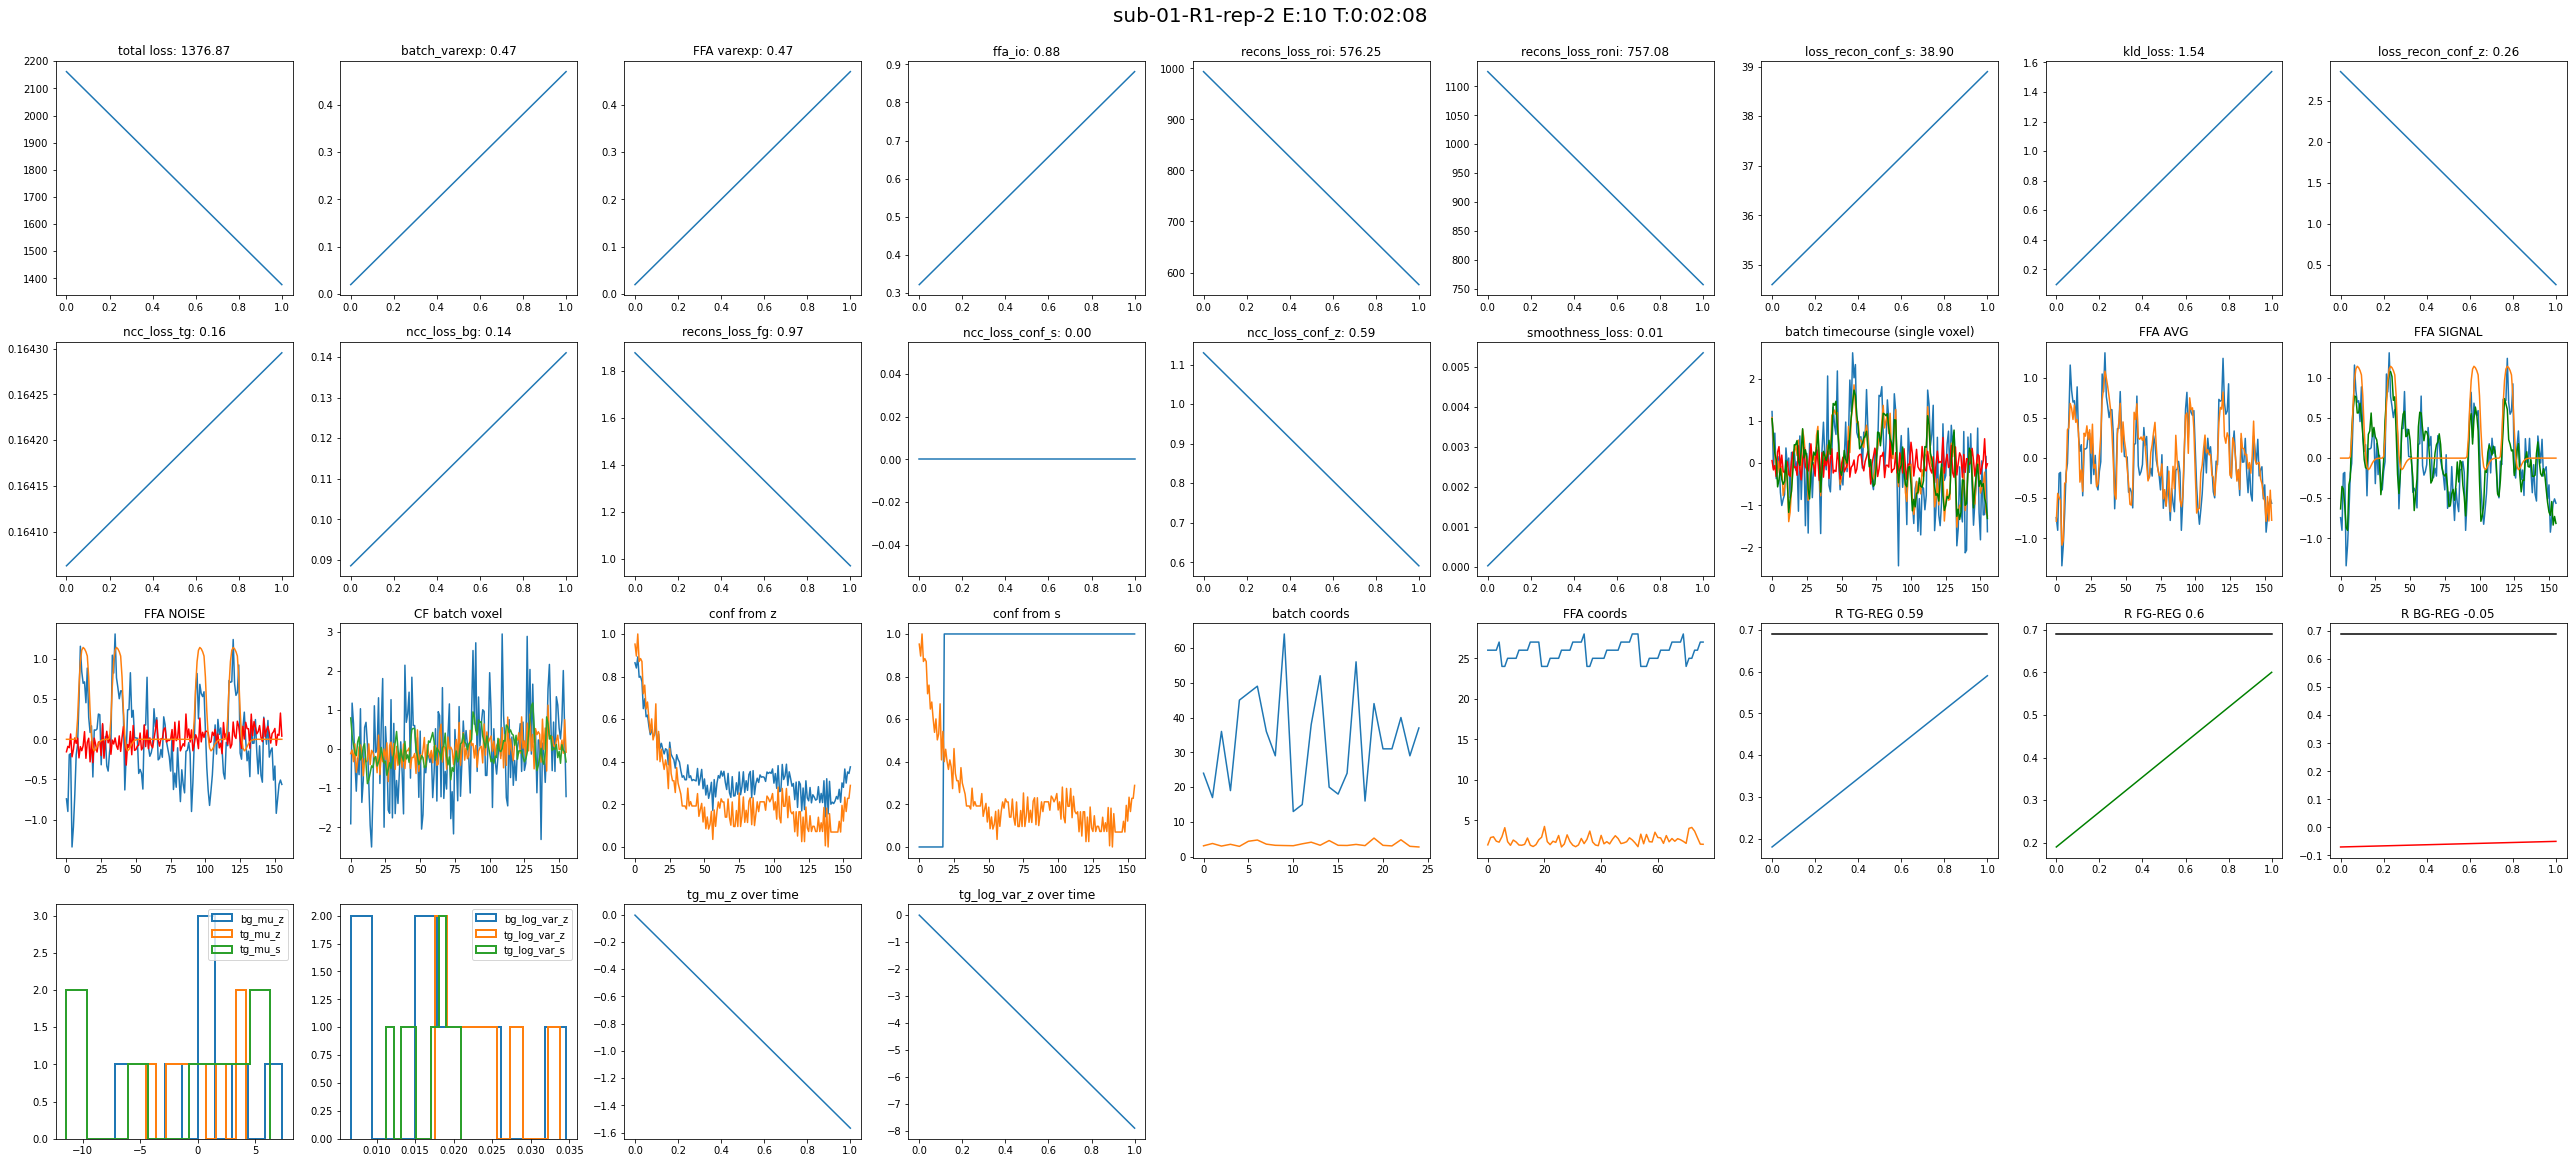

100%|██████████| 81/81 [00:01<00:00, 78.65it/s]


In [49]:
nrep = 20
epoch_num = 100

for rep in range(nrep):
    try:
        ##### Hyperparameters
        batch_size = 512
        latent_dim = (8,8) # Shared,Specific
        #latent_dim = (16,16) # Shared,Specific
        #latent_dim = (12,4) # Shared,Specific
        beta = 0.01       
        gamma = 0 # TC scaling
        delta = 0 # "Denoised RONI should be zero" scaling
        scale_MSE_GM = 1e3 # Scale ROI loss 
        scale_MSE_CF = 1e3 # Scale RONI loss
        scale_MSE_FG = 0 # "Denoised should be similar to input" scaling

        
        # obs_list_coords = np.concatenate([obs_list[:,:,np.newaxis],np.stack([gm_coords for _ in range(nt)],axis=1)],axis=-1)
        # noi_list_coords = np.concatenate([noi_list[:,:,np.newaxis],np.stack([cf_coords for _ in range(nt)],axis=1)],axis=-1)
        # obs_list_coords = np.swapaxes(obs_list_coords,1,2)
        # noi_list_coords = np.swapaxes(noi_list_coords,1,2)
        train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
        train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        Tensor = TypeVar('torch.tensor')
        conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)
        ffa_list_coords_torch = torch.from_numpy(ffa_list_coords).float().to(device)
        model = cVAE(conf_batch,4,func_cf.shape[1],latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model.to(device)
        #optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        track = init_track()
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            for i in range(len(train_in_coords)):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)
        
                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)
            
                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
                
                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
            
                if np.isnan(loss['loss'].detach().cpu().numpy()):
                    print('loss is NaN')
                    break
            
                loss['loss'].backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
        
        
            if np.mod(epoch,10)==0:
                model.eval()
                
                recon = model.forward_tg(ffa_list_coords_torch)[0]
                recon_coords = recon.detach().cpu().numpy()[:,1::,:]
                recon = recon.detach().cpu().numpy()[:,0,:]
                
                signal = model.forward_fg(ffa_list_coords_torch)[0]
                signal_coords = signal.detach().cpu().numpy()[:,1::,:]
                signal = signal.detach().cpu().numpy()[:,0,:]
                
                noise = model.forward_bg(ffa_list_coords_torch)[0]
                noise_coords = noise.detach().cpu().numpy()[:,1::,:]
                noise = noise.detach().cpu().numpy()[:,0,:]
        
                confounds_pred_z = model.decoder_confounds_z(torch.unsqueeze(tg_z,2)).detach().cpu().numpy()
                confounds_pred_s = model.decoder_confounds_s(torch.unsqueeze(tg_s,2)).detach().cpu().numpy()
                
                
                SST = ((ffa_list_coords[:,0,:]-ffa_list_coords[:,0,:].mean())**2).sum()
                SSM = ((ffa_list_coords[:,0,:]-recon)**2).sum()
                varexp = 1-SSM/SST
                varexp = varexp.round(2)
                
                batch_signal = model.forward_fg(inputs_gm)[0].detach().cpu().numpy()
                batch_noise = model.forward_bg(inputs_gm)[0].detach().cpu().numpy()
                
                batch_in = inputs_gm.detach().cpu().numpy()
                batch_out = outputs_gm.detach().cpu().numpy()
                
                batch_SST = ((batch_in[:,0,:]-batch_in[:,0,:].mean(axis=0))**2).sum()
                batch_SSM = ((batch_in[:,0,:]-batch_out[:,0,:])**2).sum()
                batch_varexp = (1-batch_SSM/batch_SST).round(2)
                
                c_t = np.array([np.corrcoef(ffa_list_coords[:,0,:].mean(axis=0),face_reg)[0,1],
                np.corrcoef(recon.mean(axis=0),face_reg)[0,1],
                np.corrcoef(signal.mean(axis=0),face_reg)[0,1],
                np.corrcoef(noise.mean(axis=0),face_reg)[0,1],]).round(2)
                
                c_io = np.corrcoef(ffa_list_coords[:,0,:].mean(axis=0),recon.mean(axis=0))[0,1]
                        
                l = loss['loss'].detach().cpu().numpy()
                kld_loss = loss['kld_loss'].detach().cpu().numpy()
                recons_loss_roi = loss['recons_loss_roi'].detach().cpu().numpy()
                recons_loss_roni = loss['recons_loss_roni'].detach().cpu().numpy()
                loss_recon_conf_s = loss['loss_recon_conf_s'].detach().cpu().numpy()
                loss_recon_conf_z = loss['loss_recon_conf_z'].detach().cpu().numpy()
                ncc_loss_tg = loss['ncc_loss_tg'].detach().cpu().numpy()
                ncc_loss_bg = loss['ncc_loss_bg'].detach().cpu().numpy()
                ncc_loss_conf_s = loss['ncc_loss_conf_s'].detach().cpu().numpy()
                ncc_loss_conf_z = loss['ncc_loss_conf_z'].detach().cpu().numpy()
                smoothness_loss = loss['smoothness_loss'].detach().cpu().numpy()
                recons_loss_fg = loss['recons_loss_fg'].detach().cpu().numpy()
                
                        
                elapsed = str(now()-t0).split('.')[0]
                #print(f'T:{elapsed} E:{epoch:03d} Vb:{batch_varexp:.2f} Vf:{varexp:.2f} c_io:{c_io:.2f} FFA-reg:{c_t[0]:.2f} TG-reg:{c_t[1]:.2f} FG-reg:{c_t[2]:.2f} BG-reg:{c_t[3]:.2f} Loss:{l:.2f} ROI:{recons_loss_roi:.2f} RONI:{recons_loss_roni:.2f} KL:{kld_loss:.2f} mse_conf_z:{loss_recon_conf_z:.2f} mse_conf_s:{loss_recon_conf_s:.2f} ncc_tg:{ncc_loss_tg:.2f} ncc_bg:{ncc_loss_bg:.2f} ncc_conf_s:{ncc_loss_conf_s:.2f} ncc_conf_z:{ncc_loss_conf_z:.2f} smooth:{smoothness_loss:.2f} delta:{recons_loss_fg:.2f}')
        
        
                track['r_ffa_reg'].append(c_t[0])
                track['r_TG_reg'].append(c_t[1])
                track['r_FG_reg'].append(c_t[2])
                track['r_BG_reg'].append(c_t[3])
                track['varexp'].append(varexp)
                track['batch_varexp'].append(varexp)
                track['ffa_io'].append(float(c_io))
                track['l'].append(float(l))
                track['kld_loss'].append(float(kld_loss))
                track['recons_loss_roi'].append(float(recons_loss_roi))
                track['recons_loss_roni'].append(float(recons_loss_roni))
                track['loss_recon_conf_s'].append(float(loss_recon_conf_s))
                track['loss_recon_conf_z'].append(float(loss_recon_conf_z))
                track['ncc_loss_tg'].append(float(ncc_loss_tg))
                track['ncc_loss_bg'].append(float(ncc_loss_bg))
                track['ncc_loss_conf_s'].append(float(ncc_loss_conf_s))
                track['ncc_loss_conf_z'].append(float(ncc_loss_conf_z))
                track['smoothness_loss'].append(float(smoothness_loss))
                track['recons_loss_fg'].append(float(recons_loss_fg))
        
                track['tg_mu_z'].append( tg_mu_z.detach().cpu().numpy()[0,0] )
                track['tg_log_var_z'].append( tg_log_var_z.detach().cpu().numpy()[0,0] )
                track['tg_mu_s'].append( tg_mu_s.detach().cpu().numpy()[0,0] )
                track['tg_log_var_s'].append( tg_log_var_s.detach().cpu().numpy()[0,0] )
                track['tg_z'].append( tg_z.detach().cpu().numpy()[0,0] )
                track['tg_s'].append( tg_s.detach().cpu().numpy()[0,0] )
                track['bg_log_var_z'].append( bg_log_var_z.detach().cpu().numpy()[0,0] )
                track['bg_mu_z'].append( bg_mu_z.detach().cpu().numpy()[0,0] )
        
                if len(track['r_ffa_reg'])>5:
                    track['r_ffa_reg'] = track['r_ffa_reg'][1::]
                    track['r_TG_reg'] = track['r_TG_reg'][1::]
                    track['r_FG_reg'] = track['r_FG_reg'][1::]
                    track['r_BG_reg'] = track['r_BG_reg'][1::]
                    track['varexp'] = track['varexp'][1::]
                    track['batch_varexp'] = track['batch_varexp'][1::]
                    track['ffa_io'] = track['ffa_io'][1::]
                    track['l'] = track['l'][1::]
                    track['kld_loss'] = track['kld_loss'][1::]
                    track['recons_loss_roi'] = track['recons_loss_roi'][1::]
                    track['recons_loss_roni'] = track['recons_loss_roni'][1::]
                    track['loss_recon_conf_s'] = track['loss_recon_conf_s'][1::]
                    track['loss_recon_conf_z'] = track['loss_recon_conf_z'][1::]
                    track['ncc_loss_tg'] = track['ncc_loss_tg'][1::]
                    track['ncc_loss_bg'] = track['ncc_loss_bg'][1::]
                    track['ncc_loss_conf_s'] = track['ncc_loss_conf_s'][1::]
                    track['ncc_loss_conf_z'] = track['ncc_loss_conf_z'][1::]
                    track['smoothness_loss'] = track['smoothness_loss'][1::]
                    track['recons_loss_fg'] = track['recons_loss_fg'][1::]
                    track['tg_mu_z'] = track['tg_mu_z'][1::]
                    track['tg_log_var_z'] = track['tg_log_var_z'][1::]
                    track['tg_mu_s'] = track['tg_mu_s'][1::]
                    track['tg_log_var_s'] = track['tg_log_var_s'][1::]
                    track['tg_z'] = track['tg_z'][1::]
                    track['tg_s'] = track['tg_s'][1::]
                    track['bg_log_var_z'] = track['bg_log_var_z'][1::]
                    track['bg_mu_z'] = track['bg_mu_z'][1::]
        
                show_bashboard()
        
        outputs = {
            'recon' : recon,
            'recon_coords' : recon_coords,
            'signal' : signal,
            'signal_coords' : signal_coords,
            'noise' : noise,
            'noise_coords' : noise_coords,
            'ffa' : ffa_list_coords[:,0,:],
            'ffa_coords' : ffa_list_coords[:,1::,:],
            'ffa_compcorr' : ffa_compcorr,
        'face_reg' : face_reg,
        'place_reg' : place_reg,
        'confounds' : conf}
        
        
        outputs_ofn = os.path.join(ofdir,f'outputs_S{s}_R{r}_rep_{rep}.pickle')
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        with open(track_ofn, 'wb') as handle:
            pickle.dump(track, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open(outputs_ofn, 'wb') as handle:
            pickle.dump(outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss, 
        }, model_ofn)
        
        model.eval()
        train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=False, num_workers=1,drop_last=False)
        dataloader_iter_in = iter(train_in_coords)
        brain_signals=[]
        for i in tqdm(range(len(dataloader_iter_in))):
            inputs_gm,inputs_cf = next(dataloader_iter_in)
            inputs_gm = inputs_gm.float().to(device)
            inputs_cf = inputs_cf.float().to(device)
            brain_signals.append(model.forward_fg(inputs_gm)[0].detach().cpu().numpy()[:,0,:])
        
        brain_signals_arr = np.zeros(epi_flat.shape)
        #brain_signals_arr[gm_flat==1,:][std0_gm==False,:] = np.vstack(brain_signals)
        #brain_signals_arr[gm_flat==1,:] = np.vstack(brain_signals)
        brain_signals_arr[(gm_flat==1) * (epi_flat.std(axis=1)>1e-3),:] = np.vstack(brain_signals)
        brain_signals_arr = brain_signals_arr.reshape(epi.shape)
        brain_signals_arr = epi.new_image_like(brain_signals_arr)
        
        signal_ofn = os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz')
        brain_signals_arr.to_filename(signal_ofn)

        #plt.savefig(os.path.join(ofdir,f'dashboard_S{s}_R{r}_rep_{rep}.png'))
        
        
    except:
        pass

In [55]:
output_files = [os.path.join(ofdir,val) for val in os.listdir(ofdir) if val.startswith(f'outputs_S{s}_R{r}_') ]
track_files = [os.path.join(ofdir,val) for val in os.listdir(ofdir) if val.startswith(f'track_S{s}_R{r}_') ]

output_files.sort()
track_files.sort()
print(f'{len(output_files)}/{len(track_files)}')

3/3


In [56]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [57]:
outputs = [load_pickle(output_file) for output_file in output_files]
tracks = [load_pickle(track_file) for track_file in track_files]

In [58]:
signals = np.array([output['signal'].mean(axis=0) for output in outputs])

In [59]:
signals = np.array([output['signal'] for output in outputs])
#signals = signals.mean(axis=1)
signals = np.median(signals,axis=1)

In [60]:
signal_avg = np.average(signals,axis=0)
signal_med = np.median(signals,axis=0)
#signal_gmm = get_stable_estimate(signals,n=10)

In [61]:
r_ffa = np.corrcoef(ffa_list_coords[:,0,:].mean(axis=0),face_reg)[0,1]
r_compcor = np.corrcoef(ffa_compcorr.mean(axis=0),face_reg)[0,1]
r_fg_med = np.corrcoef(signal_med,face_reg)[0,1]

In [62]:
print(r_ffa.round(2))
print(r_compcor.round(2))
print(r_fg_med.round(2))

0.69
0.71
0.66


Text(0.5, 1.0, 'Improvement')

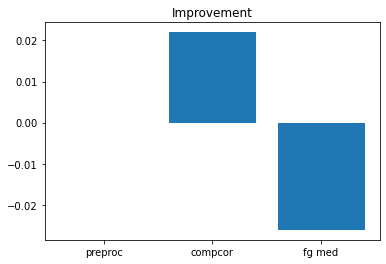

In [63]:
xs = [0,1,2]
ys = np.array([r_ffa,r_compcor,r_fg_med])
ys = ys-ys[0]
plt.bar(xs,ys)
plt.xticks(xs,labels=['preproc','compcor','fg med']);
plt.title('Improvement')

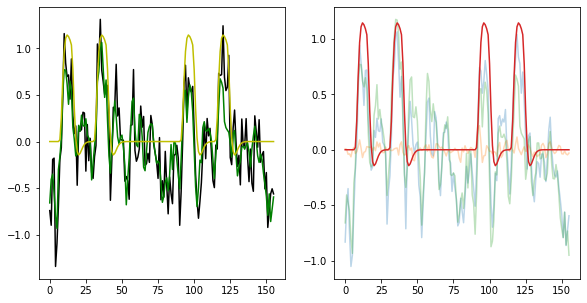

In [64]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(ffa_list_coords[:,0,:].mean(axis=0),'k-')
plt.plot(signal_med,'g-')
plt.plot(face_reg,'y-')

plt.subplot(1,3,2)
#plt.plot(ffa_list_coords[:,0,:].mean(axis=0),'k-')
plt.plot(signals.transpose(),alpha=.3)
plt.plot(face_reg)

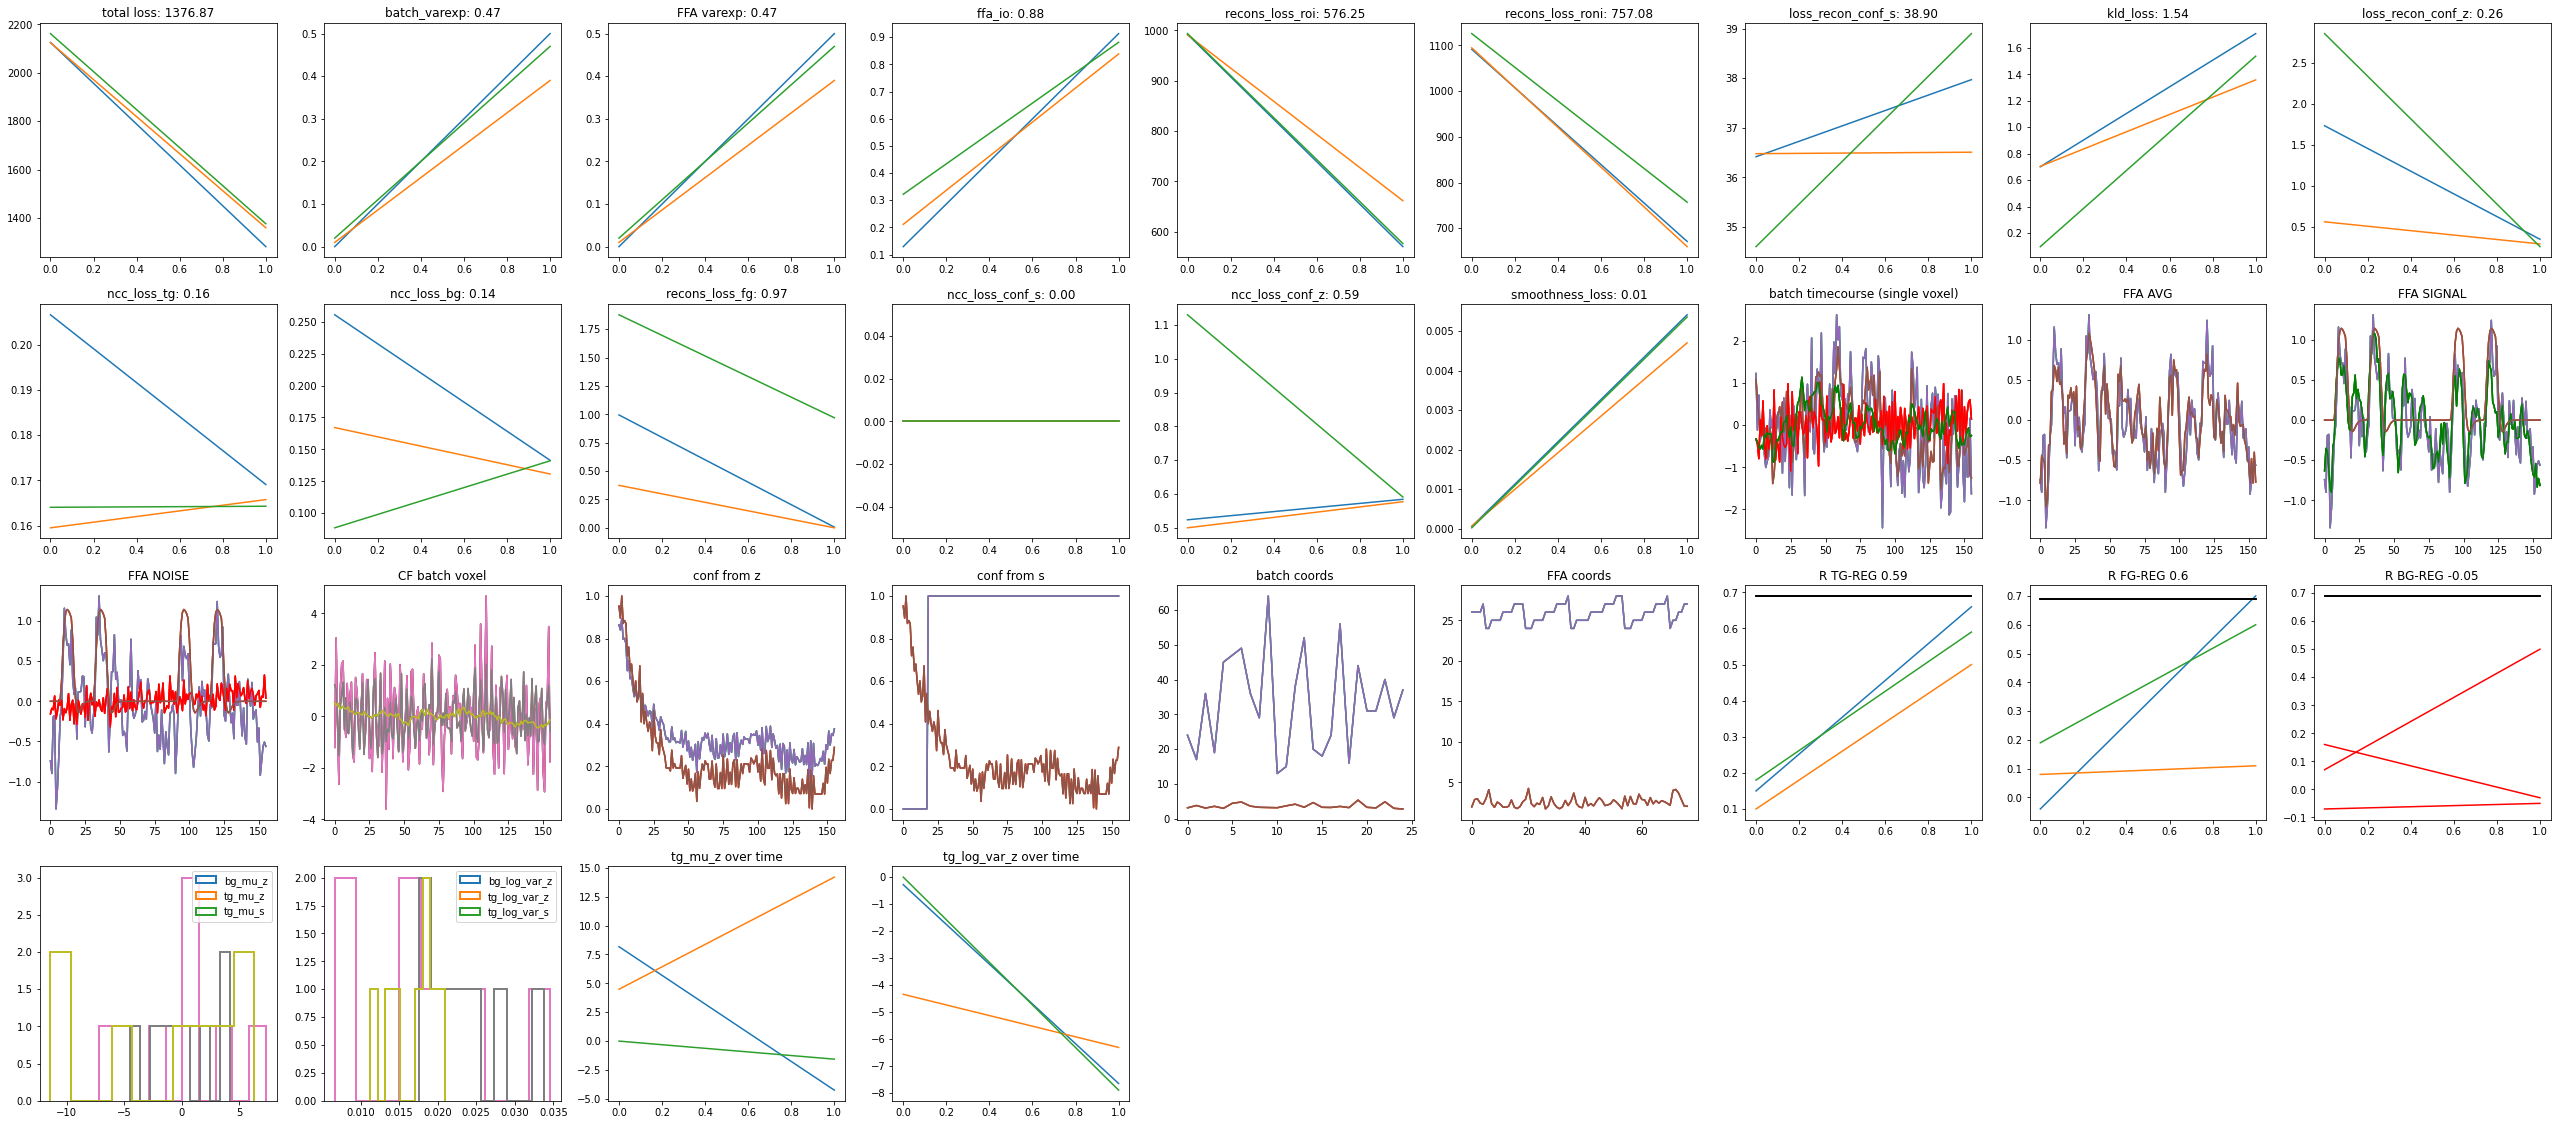

In [69]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5*9,5*5))
for track in tracks:
    show_bashboard(single_fig=False)